In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keyword-detection-dataset/keyword2tumor_type.csv
/kaggle/input/keyword-detection-dataset/train.csv
/kaggle/input/keyword-detection-dataset/test.csv
/kaggle/input/html-files/86.html
/kaggle/input/html-files/23.html
/kaggle/input/html-files/134.html
/kaggle/input/html-files/10.html
/kaggle/input/html-files/126.html
/kaggle/input/html-files/83.html
/kaggle/input/html-files/79.html
/kaggle/input/html-files/105.html
/kaggle/input/html-files/145.html
/kaggle/input/html-files/54.html
/kaggle/input/html-files/15.html
/kaggle/input/html-files/51.html
/kaggle/input/html-files/55.html
/kaggle/input/html-files/114.html
/kaggle/input/html-files/136.html
/kaggle/input/html-files/47.html
/kaggle/input/html-files/48.html
/kaggle/input/html-files/112.html
/kaggle/input/html-files/33.html
/kaggle/input/html-files/93.html
/kaggle/input/html-files/137.html
/kaggle/input/html-files/87.html
/kaggle/input/html-files/32.html
/kaggle/input/html-files/46.html
/kaggle/input/html-files/11.html
/kagg

# 0 Objective
Your task is to create an algorithm, that takes html page as input and infers if the page contains the information about cancer tumorboard or not. What is a tumor board? Tumor Board is a consilium of doctors (usually from different disciplines) discussing cancer cases in their departments. If you want to know more please read this article.

The expected result is a CSV file for test data with columns `doc_id` and `prediction`.

Bonus: if you would like to go the extra mile in this task try to identify tumor board types interdisciplinary, breast, and any third type of tumor board up to you. For these tumor boards please try to identify their schedule: Day (e.g. Friday), frequency (e.g. weekly, bi-weekly, monthly), and time when they start.

Data Description
You have `train.csv` and `test.csv` files and folder with corresponding `.html` files.

Files:

* `train.csv` contains next columns: `url`, `doc_id` and `label`
* `test.csv` contains next columns: `url` and `doc_id`
* `htmls` contains files with names `{doc_id}.html`
* `keyword2tumor_type.csv` contains useful keywords for types of tumorboards

Description of tumor board labels:

* 1 (no evidence): tumor boards are not mentioned on the page
* 2 (medium confidence): tumor boards are mentioned, but the page is not completely dedicated to tumor board description
* 3 (high confidence): page is completely dedicated to the description of tumor board types and dates

You are asked to prepare a model using htmls, referred to in train.csv, and make predictions for htmls from test.csv

Practicalities
You should prepare a Jupyter Notebook with the code that you used for making the predictions and the following documentation:

* How did you decide to handle this amount of data?
* How did you decide to do feature engineering?
* How did you decide which models to try (if you decide to train any models)?
* How did you perform validation of your model?
* What metrics did you measure?
* How do you expect your model to perform on test data (in terms of your metrics)?
* How fast will your algorithm performs and how could you improve its performance if you would have more time?
* How do you think you would be able to improve your algorithm if you would have more data?
* What potential issues do you see with your algorithm?

# 1-a Data Loading (CSV files)

## Import Statements

In [2]:
#pandas and numpy
import pandas as pd
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings(action='ignore')

#beautifulsoup import
from bs4 import BeautifulSoup

#test parsing (for the html text)
from gensim.parsing import preprocessing

In [17]:
#graphing imports
import seaborn as sns
import matplotlib.pyplot as plt

## CSV First Looks

In [3]:
train_csv = pd.read_csv('/kaggle/input/keyword-detection-dataset/train.csv')
print('Training data set shape: ', train_csv.shape)
train_csv.head()

Training data set shape:  (100, 3)


,url,doc_id,label
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3


In [4]:
train_csv.label.value_counts()

label
2    59
1    32
3     9
Name: count, dtype: int64

In [5]:
test_csv = pd.read_csv('/kaggle/input/keyword-detection-dataset/test.csv')
print('Test data set shape: ', test_csv.shape)
test_csv.head()

Test data set shape:  (48, 2)


,url,doc_id
0,http://chirurgie-goettingen.de/medizinische-ve...,0
1,http://evkb.de/kliniken-zentren/chirurgie/allg...,2
2,http://krebszentrum.kreiskliniken-reutlingen.d...,7
3,http://marienhospital-buer.de/mhb-av-chirurgie...,15
4,http://marienhospital-buer.de/mhb-av-chirurgie...,16


In [6]:
keywords_csv = pd.read_csv('/kaggle/input/keyword-detection-dataset/keyword2tumor_type.csv')
print('Keywords data set shape: ', keywords_csv.shape)
keywords_csv.head()

Keywords data set shape:  (126, 2)


,keyword,tumor_type
0,senologische,Brust
1,brustzentrum,Brust
2,breast,Brust
3,thorax,Brust
4,thorakale,Brust


# 1-b Loading Data (HTML Files)

## HTML read function

In [7]:
#HTML read function

def read_html(doc_id: int) -> str:
    with open(file=f'/kaggle/input/html-files/{doc_id}.html',
             mode='r',
             encoding='latin1') as f:
        html = f.read()
    return html

In [8]:
#Apply using doc_id to create html column
train_csv['html'] = train_csv.doc_id.apply(read_html)

In [9]:
train_csv.sample(n=5, random_state=20)

,url,doc_id,label,html
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<..."
74,http://www.marienhospital-stuttgart.de/aerzte-...,112,1,"<!DOCTYPE html>\n<html class=""no-js"" lang=""de""..."
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<..."
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T..."
56,http://www.klinikum-fichtelgebirge.de/leistung...,89,3,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<..."


## HTML Extract Function

In [10]:
#extraction function for each html item
def extract_html(html):
    bs = BeautifulSoup(markup=html, features='lxml')
    for script in bs(name=['script', 'style']):
        script.decompose()
    return bs.get_text(separator=' ')

In [11]:
#create html_text column
train_csv['html_text'] = train_csv.html.apply(extract_html)

In [12]:
train_csv.sample(n=5, random_state=20)

,url,doc_id,label,html,html_text
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
74,http://www.marienhospital-stuttgart.de/aerzte-...,112,1,"<!DOCTYPE html>\n<html class=""no-js"" lang=""de""...",Klinische Studien â Marienhospital Stuttgart...
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<...",\n \n Zentrum - SozialpÃ¤diatrisches Zentrum -...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
56,http://www.klinikum-fichtelgebirge.de/leistung...,89,3,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...


# 1-c HTML Pre Processing

In [13]:
#this set of gensim parsing functions was new to me for this project, lots of promising capabilities to use for page processing

# non_alphanums: Remove non-alphabetic characters from s using RE_NONALPHA
# multiple_whitespaces: Remove repeating whitespace characters (spaces, tabs, line breaks) from s and turns tabs & line breaks into spaces using RE_WHITESPACE
# punctuation: Replace punctuation characters with spaces in s using RE_PUNCT
# numeric: Remove digits from s using RE_NUMERIC
# stem_text: Transform s into lowercase and stem it.
# stopwords: Remove STOPWORDS from s

def preprocess_html(html_text: str) -> str:
    preprocessed_text = preprocessing.strip_non_alphanum(s=html_text) #start with html_text, recursive for further calls
    preprocessed_text = preprocessing.strip_multiple_whitespaces(s=preprocessed_text)
    preprocessed_text = preprocessing.strip_punctuation(s=preprocessed_text)
    preprocessed_text = preprocessing.strip_numeric(s=preprocessed_text)
    preprocessed_text = preprocessing.stem_text(text = preprocessed_text)
    preprocessed_text = preprocessing.remove_stopwords(s=preprocessed_text)
    return preprocessed_text

In [14]:
train_csv['preprocessed_html_text'] = train_csv.html_text.apply(preprocess_html)

In [16]:
train_csv.sample(n=5, random_state=20)

,url,doc_id,label,html,html_text,preprocessed_html_text
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,maltes kliniken rhein ruhr darmzentrum duisbur...
74,http://www.marienhospital-stuttgart.de/aerzte-...,112,1,"<!DOCTYPE html>\n<html class=""no-js"" lang=""de""...",Klinische Studien â Marienhospital Stuttgart...,klinisch studien â marienhospit stuttgart mari...
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<...",\n \n Zentrum - SozialpÃ¤diatrisches Zentrum -...,zentrum sozialpã diatrisch zentrum stã dtisch ...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,mund kiefer und plastisch gesichtschirurgi en ...
56,http://www.klinikum-fichtelgebirge.de/leistung...,89,3,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,klinikum fichtelgebirg chirurgisch klinik â al...


# 2 Exploration

<Figure size 640x480 with 0 Axes>

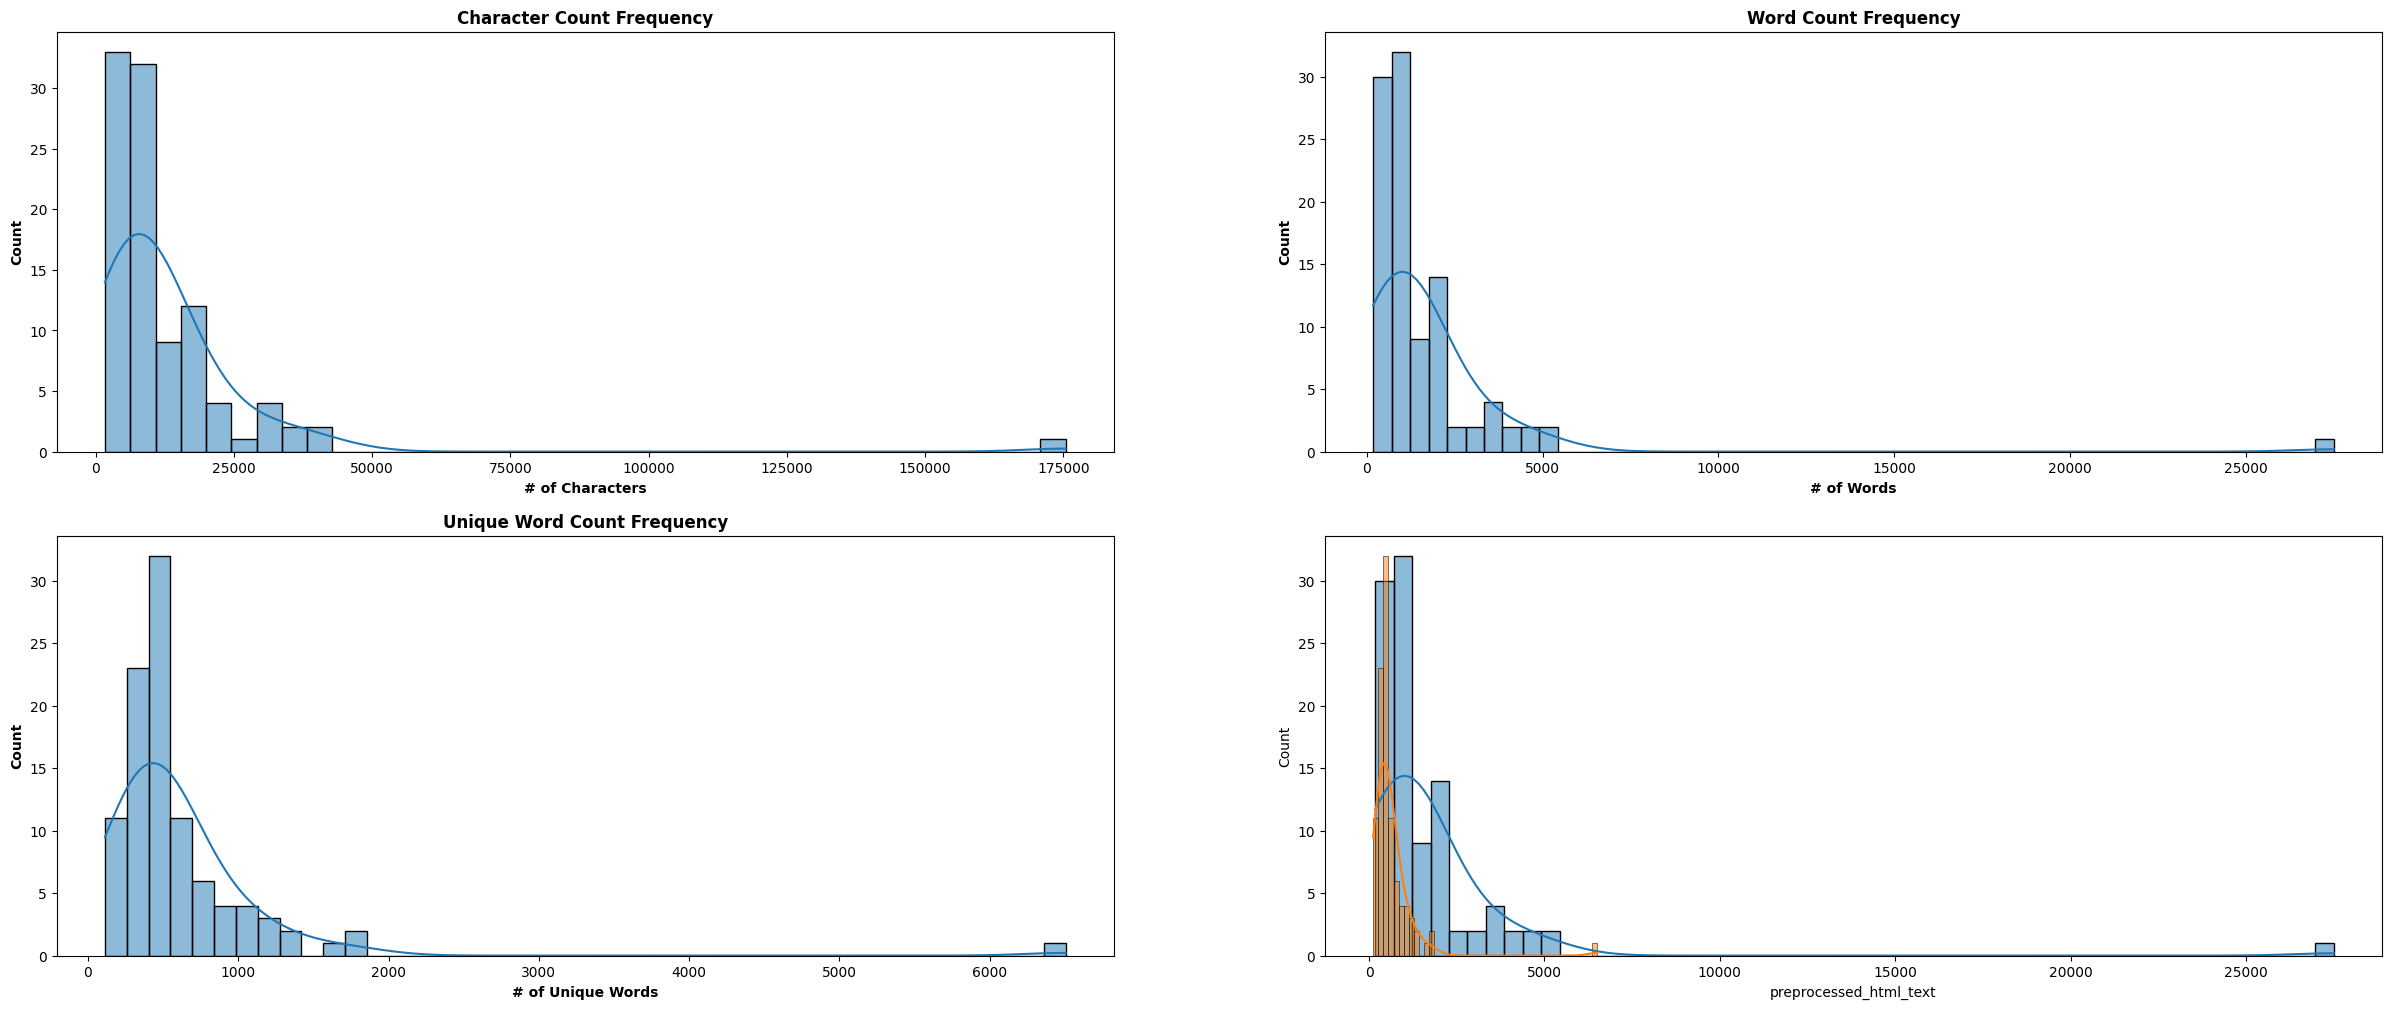

In [34]:
plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(30,12))
axes = axes.flatten()

#text length per page histogram
x0 = train_csv.preprocessed_html_text.apply(len)
sns.histplot(x0, kde=True, ax=axes[0])
axes[0].set_title('Character Count Frequency', fontweight='bold')
axes[0].set_xlabel('# of Characters', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')

x1 = train_csv.preprocessed_html_text.apply(lambda x: x.split(' ')).apply(len)
sns.histplot(x1, kde=True, ax=axes[1])
axes[1].set_title('Word Count Frequency', fontweight='bold')
axes[1].set_xlabel('# of Words', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')

x2 = train_csv.preprocessed_html_text.apply(lambda x: set(x.split(' '))).apply(len)
sns.histplot(x2, kde=True, ax=axes[2])
axes[2].set_title('Unique Word Count Frequency', fontweight='bold')
axes[2].set_xlabel('# of Unique Words', fontweight='bold')
axes[2].set_ylabel('Count', fontweight='bold')
#plt.tight_layout()

#combo chart
sns.histplot(x1, kde=True, ax=axes[3])
sns.histplot(x2, kde=True, ax=axes[3])

plt.show()

**Observation**
* There is 1 document outlier with 170k+ characters / 26k+ words
* Other documents are less than 50k characters / less than 6k words 